# Problem Description

In the post-pandemic scenario, as cinemas across the US open again, a large cinema property owner MMC Seracado wants to detect human who are wearing face masks correctly, incorrectly, and not wearing at all.

Build a Transfer learning model to detect face masks on humans.

# Dataset Description

The zip folder contains 2 folders train and test each folder with 3 subfolders labelled as to which class they belong to. 

The 2 classes are 

- "with_mask"
- "without_mask"

Each image is of shape 128, 128, 3.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import gc
from keras import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

2025-04-26 18:54:26.543533: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-26 18:54:26.543899: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-26 18:54:26.546279: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-26 18:54:26.552130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745711666.562154     412 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745711666.56

In [2]:
import os
import shutil
import random

def organize_images(folder_groups, output_dir='processed_data', split_ratio=0.8):
    """
    folder_groups: list of tuples, each like (class_name, [folder1, folder2, ...])
    output_dir: base output directory
    split_ratio: proportion of data to be used for training
    """
    train_dir = os.path.join(output_dir, 'train')
    test_dir = os.path.join(output_dir, 'test')

    # Create destination folders
    for class_name, _ in folder_groups:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Go through each class group
    for class_name, source_folders in folder_groups:
        all_files = []
        for folder in source_folders:
            files = [os.path.join(folder, f) for f in os.listdir(folder)
                     if os.path.isfile(os.path.join(folder, f))]
            all_files.extend(files)

        random.shuffle(all_files)
        split_idx = int(split_ratio * len(all_files))
        train_files = all_files[:split_idx]
        test_files = all_files[split_idx:]

        for f in train_files:
            shutil.copy(f, os.path.join(train_dir, class_name))
        for f in test_files:
            shutil.copy(f, os.path.join(test_dir, class_name))

folder1 = '/home/cullen-fedora/Documents/Mask Dataset/with_mask pt1/with_mask pt1'
folder2 = '/home/cullen-fedora/Documents/Mask Dataset/with_mask pt2/with_mask pt2'
folder3 = '/home/cullen-fedora/Documents/Mask Dataset/without_mask/without_mask'

folder_groups = [
    ('with', [folder1, folder2]),
    ('without', [folder3])
]

organize_images(folder_groups)

## Task A

### 1. Load the Image Training and Test Datasets from the train and test folder respectively. Each image is of shape 128x128x3

In [3]:
train_data_generator = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip = True, vertical_flip = True, zoom_range = 0.1,
    shear_range = 0.1, width_shift_range = 0.2, height_shift_range = 0.2, rotation_range = 90,
)
test_data_generator = keras.preprocessing.image.ImageDataGenerator()

### 2. Load training dataset using Keras ImageDataGenerator

In [4]:
train_data = train_data_generator.flow_from_directory("./processed_data/train", target_size = (128, 128), batch_size = 1, shuffle= True)

Found 6041 images belonging to 2 classes.


### 3. Load test dataset using Keras ImageDataGenerator

In [5]:
test_data = test_data_generator.flow_from_directory("./processed_data/test", target_size = (128, 128), batch_size = 1, shuffle= True)

Found 1512 images belonging to 2 classes.


In [6]:
labels = train_data.class_indices
labels

{'with': 0, 'without': 1}

There are 2 labels found "with_mask" and "without_mask"

ImageDataGenerator does not really assign values to an array, it just holds pointers. Because of that every learning step CPU perform reading opertions. This is very slows learning speed. We will store data in numpy array type. 

In [7]:
def get_array_from_datagen(train_data_generator):
    x = []
    y = []
    train_data_generator.reset()
    for i in range(train_data_generator.__len__()):
        a,b=next(train_data_generator)
        x.append(a)
        y.append(b)
    x = np.array(x, dtype= np.float32)
    y = np.array(y, dtype= np.float32)
    print(x.shape)
    print(y.shape)
    return x, y
X_train, y_train = get_array_from_datagen(train_data)
X_test, y_test = get_array_from_datagen(test_data)


# x.shape (num_samples, height, width, channels)
# y.shape (num_samples, num_classes)
# 1 in second column represents the batch size (need to reshape)

/home/cullen-fedora/Documents/Python-Projects/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(6041, 1, 128, 128, 3)
(6041, 1, 2)
(1512, 1, 128, 128, 3)
(1512, 1, 2)


In [8]:
# Reshape the data to match the input shape of the model
X_train = X_train.reshape(-1, 128, 128, 3) 
X_test = X_test.reshape(-1, 128, 128, 3)

y_train = y_train.reshape(-1, 2)
y_test = y_test.reshape(-1, 2)

In [9]:
input_shape = (128, 128, 3)
class_num = len(labels)

In [10]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


### 4. Build a Transfer Learning network using Keras with the following layers
- Load EfficientNetB0 as first layers using Keras API.
- GLobalAveragePooling2D layer
- Dropout(0.2)
- Dense layer with 2 neurons and activation softmax

In [11]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

2025-04-26 18:54:41.929152: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
efficient_model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax') # since we have 2 classes
])
# if you want to use 1 neuron output dense layer, use sigmoid activation with binary_crossentropy loss instead of categorical_crossentropy

### 5. Compile the model with adam optimizer, categorical_crossentropy loss and with metrics accuracy

In [13]:
efficient_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

### 6. Train the model for 6 epochs with callbacks Reduce Learning Rate on Plateau and early stopping while monitoring validation loss

In [14]:
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=0,
    factor=0.5,
    min_lr=0.00001
)
early_stopping = keras.callbacks.EarlyStopping(patience=5, verbose=1)

In [15]:
history = efficient_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=6,
    callbacks=[learning_rate_reduction, early_stopping]
)

Epoch 1/6
189/189 ━━━━━━━━━━━━━━━━━━━━ 98s 419ms/step - accuracy: 0.8954 - loss: 0.2414 - val_accuracy: 0.9874 - val_loss: 0.0425 - learning_rate: 0.0010
Epoch 2/6
189/189 ━━━━━━━━━━━━━━━━━━━━ 80s 422ms/step - accuracy: 0.9791 - loss: 0.0642 - val_accuracy: 0.9914 - val_loss: 0.0248 - learning_rate: 0.0010
Epoch 3/6
189/189 ━━━━━━━━━━━━━━━━━━━━ 75s 397ms/step - accuracy: 0.9892 - loss: 0.0375 - val_accuracy: 0.9947 - val_loss: 0.0211 - learning_rate: 0.0010
Epoch 4/6
189/189 ━━━━━━━━━━━━━━━━━━━━ 81s 429ms/step - accuracy: 0.9851 - loss: 0.0401 - val_accuracy: 0.9848 - val_loss: 0.0737 - learning_rate: 0.0010
Epoch 5/6
189/189 ━━━━━━━━━━━━━━━━━━━━ 72s 383ms/step - accuracy: 0.9910 - loss: 0.0247 - val_accuracy: 0.9788 - val_loss: 0.0772 - learning_rate: 0.0010
Epoch 6/6
189/189 ━━━━━━━━━━━━━━━━━━━━ 80s 423ms/step - accuracy: 0.9941 - loss: 0.0180 - val_accuracy: 0.9927 - val_loss: 0.0226 - learning_rate: 0.0010


### 7. Plot training and validation accuracy and loss against epochs

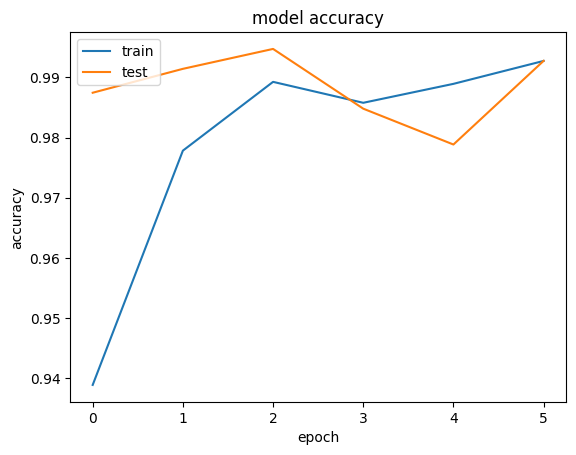

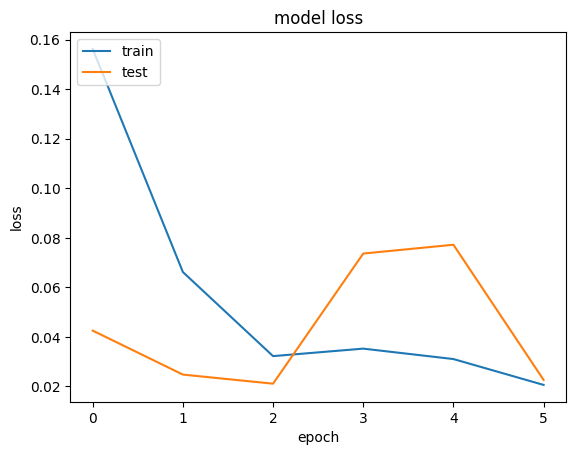

In [16]:
plot_history(history)

#### Observations:
- with this less number of epochs,
    - Train loss decreases continuously
    - Training accuracy increases smoothly
    - Validation loss also decreases continuously 
    - Validation accuracy also increases smoothly

## Task B
1. Load the Image Training and Test datasets from the train and test folder respectively. Each image is of shape 128 x 128 x3
2. Load training dataset using Keras ImageDataGenerator with validation_split=0.2
3. Load test dataset using Keras ImageDataGenerator
4. Build a Transfer Learning network using Keras with the following layers
    - Load ResNet50 as first layers using Keras API.
    - GLobalAveragePooling2D layer
    - Dropout(0.5)
    - Dense layer with 2 neurons and activation softmax

In [17]:
base_model = tf.keras.applications.ResNet50(include_top=False)
resnet_model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

### 5. Compile the model with adam optimizer, categorical_crossentropy loss and with metrics accuracy.

In [18]:
resnet_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### 6. Train the model for 6 epochs with callbacks Reduced Learning Rate on Plateau and early stopping while monitoring validation loss

In [19]:
history = resnet_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=6,
    callbacks=[learning_rate_reduction, early_stopping]
)

Epoch 1/6
189/189 ━━━━━━━━━━━━━━━━━━━━ 163s 769ms/step - accuracy: 0.8046 - loss: 0.6239 - val_accuracy: 0.6243 - val_loss: 4.4749 - learning_rate: 0.0010
Epoch 2/6
189/189 ━━━━━━━━━━━━━━━━━━━━ 145s 769ms/step - accuracy: 0.8944 - loss: 0.2805 - val_accuracy: 0.9028 - val_loss: 0.2490 - learning_rate: 0.0010
Epoch 3/6
189/189 ━━━━━━━━━━━━━━━━━━━━ 138s 729ms/step - accuracy: 0.9492 - loss: 0.1468 - val_accuracy: 0.7976 - val_loss: 0.4707 - learning_rate: 0.0010
Epoch 4/6
189/189 ━━━━━━━━━━━━━━━━━━━━ 135s 717ms/step - accuracy: 0.9647 - loss: 0.0964 - val_accuracy: 0.8909 - val_loss: 0.3366 - learning_rate: 0.0010
Epoch 5/6
189/189 ━━━━━━━━━━━━━━━━━━━━ 136s 717ms/step - accuracy: 0.9652 - loss: 0.0943 - val_accuracy: 0.9444 - val_loss: 0.1422 - learning_rate: 0.0010
Epoch 6/6
189/189 ━━━━━━━━━━━━━━━━━━━━ 136s 718ms/step - accuracy: 0.9520 - loss: 0.1377 - val_accuracy: 0.8902 - val_loss: 0.3422 - learning_rate: 0.0010


### 7. Plot training and validation accuracy and loss against epochs

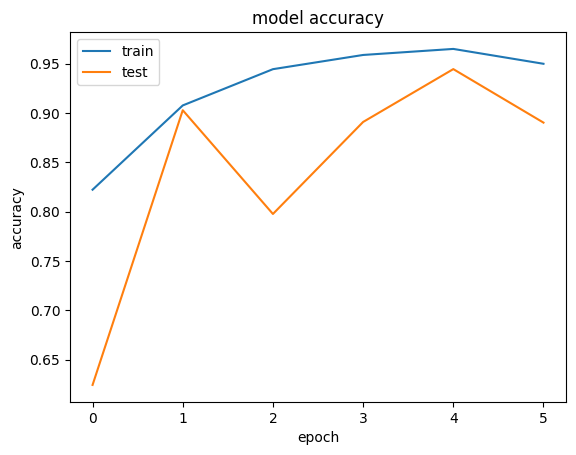

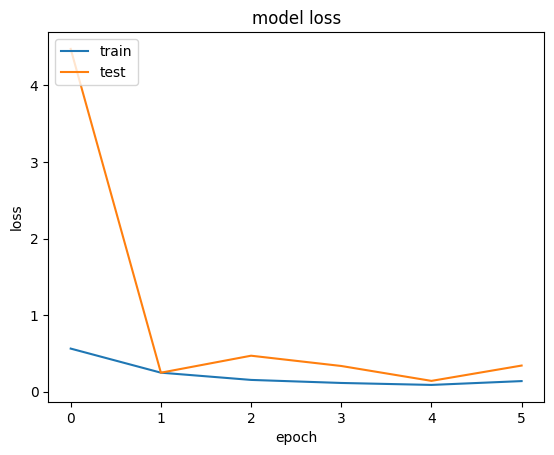

In [20]:
plot_history(history)

#### Observations
    - With this less number of epochs,
        - Train loss decreases continuously
        - Training accuracy increases smoothly
        - Validation loss shows a general trend of decreasing
        - Validation accuracy shows a general trend of increasing

## Task C
1. Compare EfficientNetB0 and ResNetB0 model performance and find the best model

In [21]:
test_loss, test_accuracy = efficient_model.evaluate(X_test, y_test, batch_size=8)
print(f"EfficientNetB0 Model Performance")
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9933 - loss: 0.0174
EfficientNetB0 Model Performance
Test loss: 0.022642219439148903
Test accuracy: 0.9927248954772949


In [22]:
test_loss, test_accuracy = resnet_model.evaluate(X_test, y_test, batch_size=8)
print(f"ResNet50 Model Performance")
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9000 - loss: 0.2824
ResNet50 Model Performance
Test loss: 0.3422497510910034
Test accuracy: 0.8902116417884827


Accuracy:

ResNet50 -> 0.8766

EfficientNet -> 0.9933

    - The accuracy level of EfficientNet is higher than Resnet50
    - The training time of EfficientNet is lesser than Resnet50
    - This is because the EfficientNet architecture is smaller than ResNet
    - the prediction time of EfficientNet is also lesser than Resnet50
    - Because of the EfficientNet model's wider layers architecture helped in achieveing this

Best Model is EfficientNet, we will check recall, precision, and f1-score values

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), efficient_model.predict(X_test).argmax(axis=1)))

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       746
           1       1.00      0.99      0.99       766

    accuracy                           0.99      1512
   macro avg       0.99      0.99      0.99      1512
weighted avg       0.99      0.99      0.99      1512



#### Observations
    - Classification report of EfficientNet says that
        - Missclassification is all the classes are very less
        - with_mask class has got an F1 score of 0.99
        - without_mask class has got an F1 score of 1

Let's look at some predictions on validation dataset

Create a small validation set of 25 images

### 2. Using the best model predict on the dataset and plot 25 images from the test set along with it's True Lable and Predicted Label.

In [24]:
import numpy as np
import os

test_images = []
test_labels = []
paths = []
names = []

# Reset the generator to ensure it starts from the beginning
test_data.reset()

# Collect 25 images
for _ in range(25):
    img_batch, labels = next(test_data) # batch_size=1
    test_images.append(img_batch[0]) # Append the first image of the batch
    test_labels.append(labels[0])

    # Compute the correct index in the filename list
    index = test_data.batch_index * test_data.batch_size - 1
    if index >= len(test_data.filenames):
        index = len(test_data.filenames) - 1 # prevent index at the end

    filepath = test_data.filenames[index]
    paths.append(filepath)

    # Extract just the name (filename without extension)
    name = os.path.splitext(os.path.basename(filepath))[0]
    names.append(name)

# Convert to numpy array: shape (25, height, width, channels)
demo_data = np.stack(test_images)

In [25]:
predictions = efficient_model.predict(demo_data).argmax(axis=1)
pred_label = []
for i in predictions:
    pred_label.append(test_labels[i])
pred_label

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


[array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32)]

FileNotFoundError: [Errno 2] No such file or directory: 'with/with_mask_1.jpg'

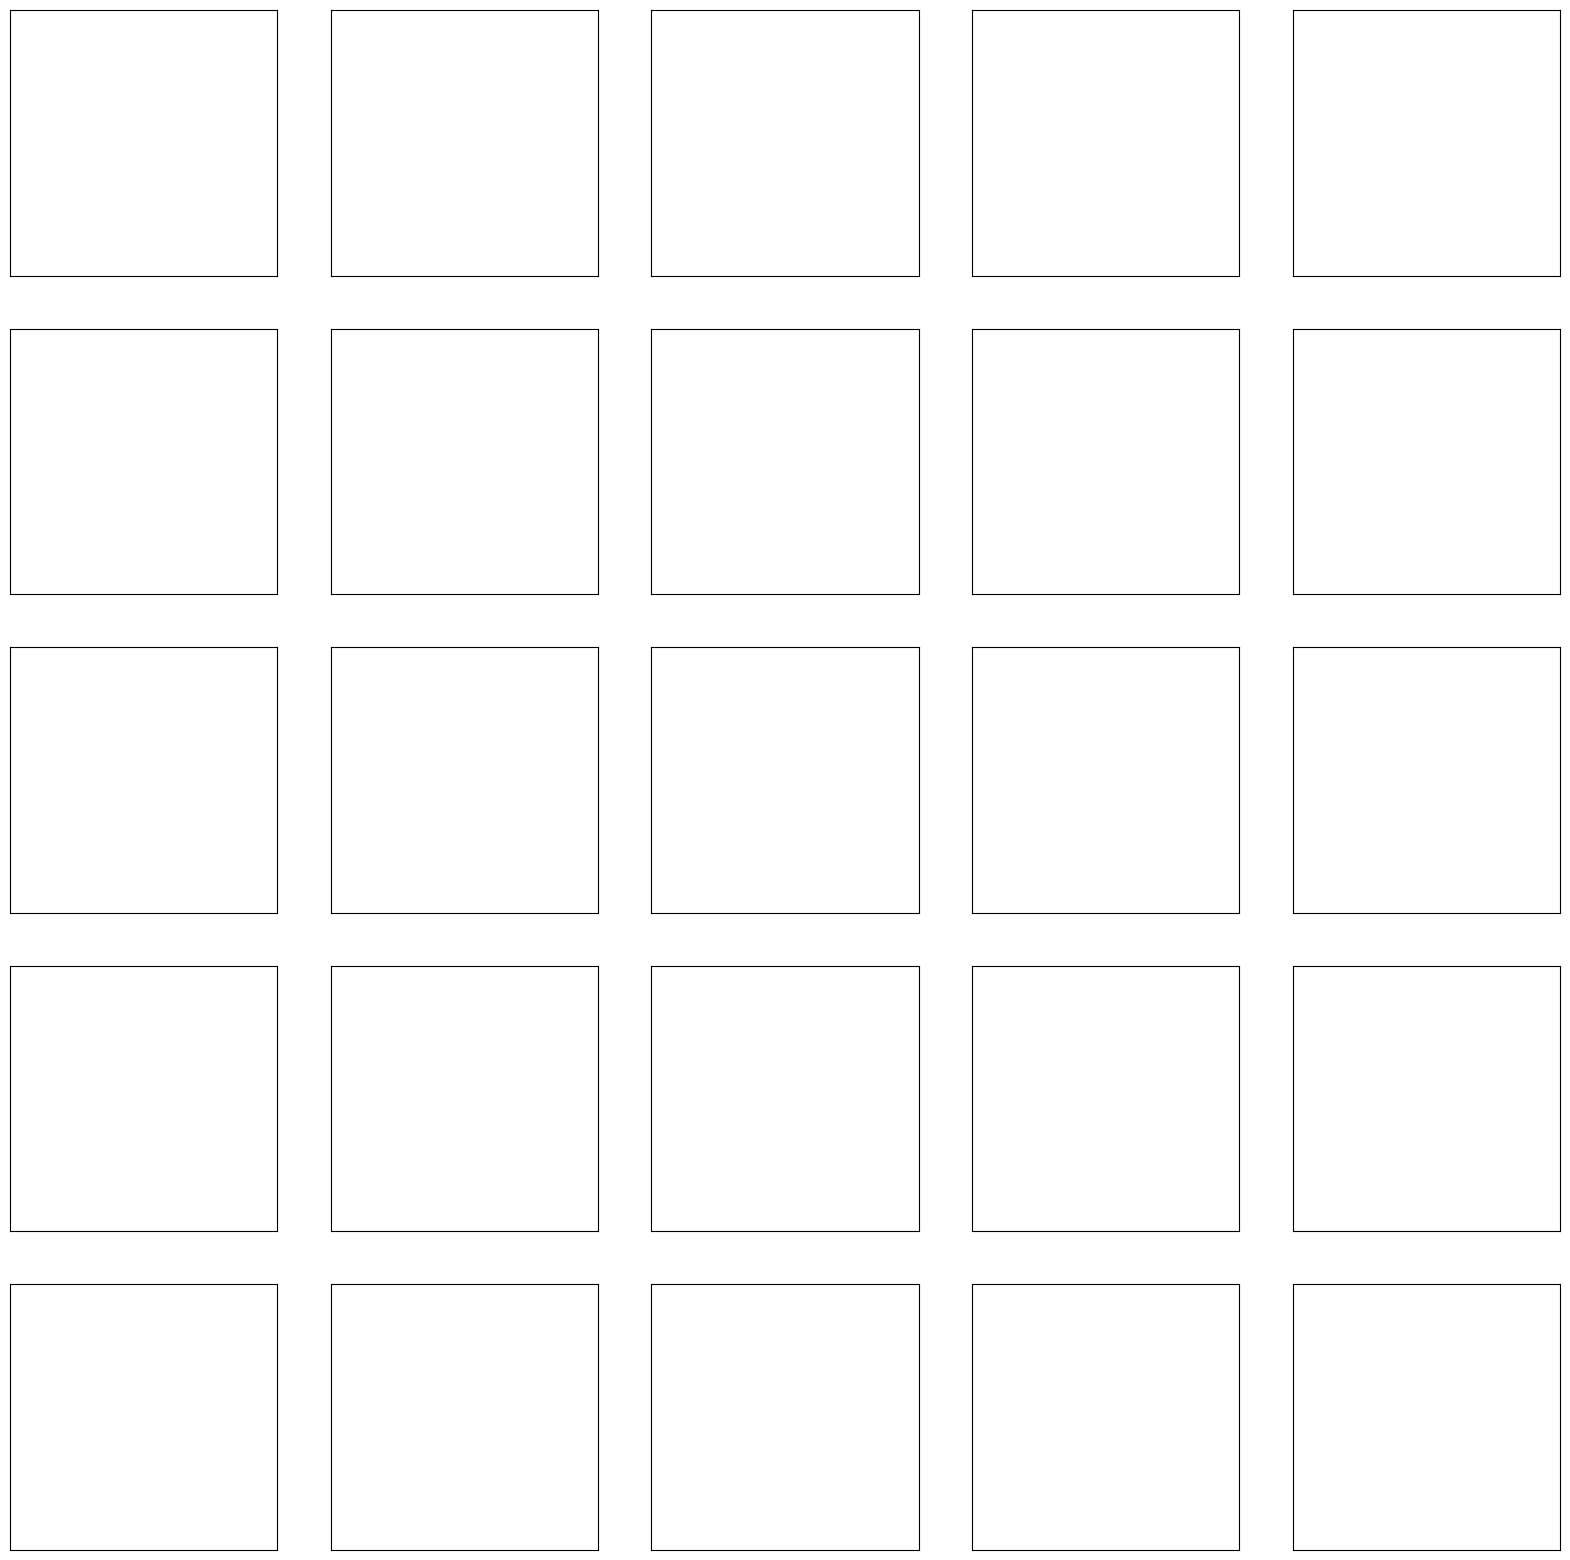

In [26]:
import os
fig, axes = plt.subplots(nrows=5,
                         ncols=5,
                         figsize=(20, 20),
                         subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(paths[i]))
    ax.set_title(f"PREDICTION: {pred_label[i]}")
    ax.set_xlabel(f"DATA: {names[i]}")
#plt.tight_layout()
plt.show()


#### Observations
- The plot shows that EfficientNet is able to correctly identify people with mask and without mask.

## Conclusion

- EfficientNet outperformed Resnt Model in classifying people wearing mask or not
- EfficientNet gave an accuracy of 99%
- Though model is trained with less epochs, this experiement proves the power of Transfer Learning
- Because these models already know the features of a person, they are able to do the job for this use case too
- Any image classification task, Transfer learning could be a good starting point
- EfficientNet, a lightweight convolutional neural network architecture achieving the state-of-the-art accuracy with an order of magnitude fewer parameters, on both ImageNet and five other commonly used transfer learning datasets.
- ResNet-50 Model is a convolutional neural network (CNN) that is 50 layers deep. A Residual Neural Network (ResNet) stacks residual blocks on top of each other to form a network.
- EfficientNet is the latest architecture than ResNet 